In [1262]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [1263]:
dataset = pd.read_csv("playground-series-s4e2/train.csv")
org_dataset = pd.read_csv("obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")

# Concatenate the two DataFrames along their rows
dataset = pd.concat([dataset, org_dataset], ignore_index=True)
dataset.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [1264]:
# Dropping columns based on low std as compare to mean
columns_to_drop = ['id']
#columns_to_drop = ['id', 'FAF', 'TUE']

dataset = dataset.drop(columns=columns_to_drop)

In [1265]:
# Example of creating a new feature: BMI
#dataset['BMI'] = dataset['Weight'] / (dataset['Height'] ** 2)

# Example of interaction term: Age * Weight
dataset['Age_Weight_Interaction'] = dataset['Age'] * dataset['Weight']

# Polynomial feature
#dataset['Age_Squared'] = dataset['Age'] ** 2

# Logarithmic transformation for skewed feature
#dataset['Log_Weight'] = np.log(dataset['Weight'])

# Square root transformation
#dataset['Sqrt_Height'] = np.sqrt(dataset['Height'])

In [1266]:
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Age_Weight_Interaction
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,1996.259486
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,1026.000000
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,902.983572
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,2750.567428
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,2967.871856


In [1267]:
# Use LabelEncoder for binary columns
binary_columns = ['Gender','family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'NObeyesdad']
label_encoder = LabelEncoder()
for col in binary_columns:
    dataset[col] = label_encoder.fit_transform(dataset[col])

In [1268]:
print("Mapping of original strings to numerical labels:")
for original, label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original}: {label}")

Mapping of original strings to numerical labels:
Insufficient_Weight: 0
Normal_Weight: 1
Obesity_Type_I: 2
Obesity_Type_II: 3
Obesity_Type_III: 4
Overweight_Level_I: 5
Overweight_Level_II: 6


In [1269]:
# One-hot encode categorical columns
categorical_columns = ['CAEC', 'CALC', 'MTRANS']
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(dataset[col], prefix=col)
    dataset = pd.concat([dataset, one_hot_encoded], axis=1)
    dataset.drop(columns=[col], inplace=True)

In [1270]:
# Split data into features and target
X = dataset.drop(columns=['NObeyesdad'])
y = dataset['NObeyesdad']


In [1271]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1272]:
# Apply standard scaling to numerical features after splitting
scaler = StandardScaler()
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O','Age_Weight_Interaction','FAF', 'TUE']

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [1273]:
'''# Define a parameter grid for XGBoost
param_grid = {
    'reg_alpha': [0.1, 1.0, 10.0],
    'reg_lambda': [0.1, 1.0, 10.0],
}

# Use GridSearchCV or RandomizedSearchCV for evaluation
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()
search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
search.fit(X_train, y_train)

# Print best parameters and scores
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)'''  

'# Define a parameter grid for XGBoost\nparam_grid = {\n    \'reg_alpha\': [0.1, 1.0, 10.0],\n    \'reg_lambda\': [0.1, 1.0, 10.0],\n}\n\n# Use GridSearchCV or RandomizedSearchCV for evaluation\nfrom sklearn.model_selection import GridSearchCV\n\nxgb_model = xgb.XGBClassifier()\nsearch = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)\nsearch.fit(X_train, y_train)\n\n# Print best parameters and scores\nprint("Best parameters:", search.best_params_)\nprint("Best score:", search.best_score_)'

In [1274]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

XGBoost Model:
Accuracy: 0.9011805859204197
F1 Score: 0.901172123961471
Precision: 0.9013903551346503
Recall: 0.9011805859204197
Confusion Matrix:


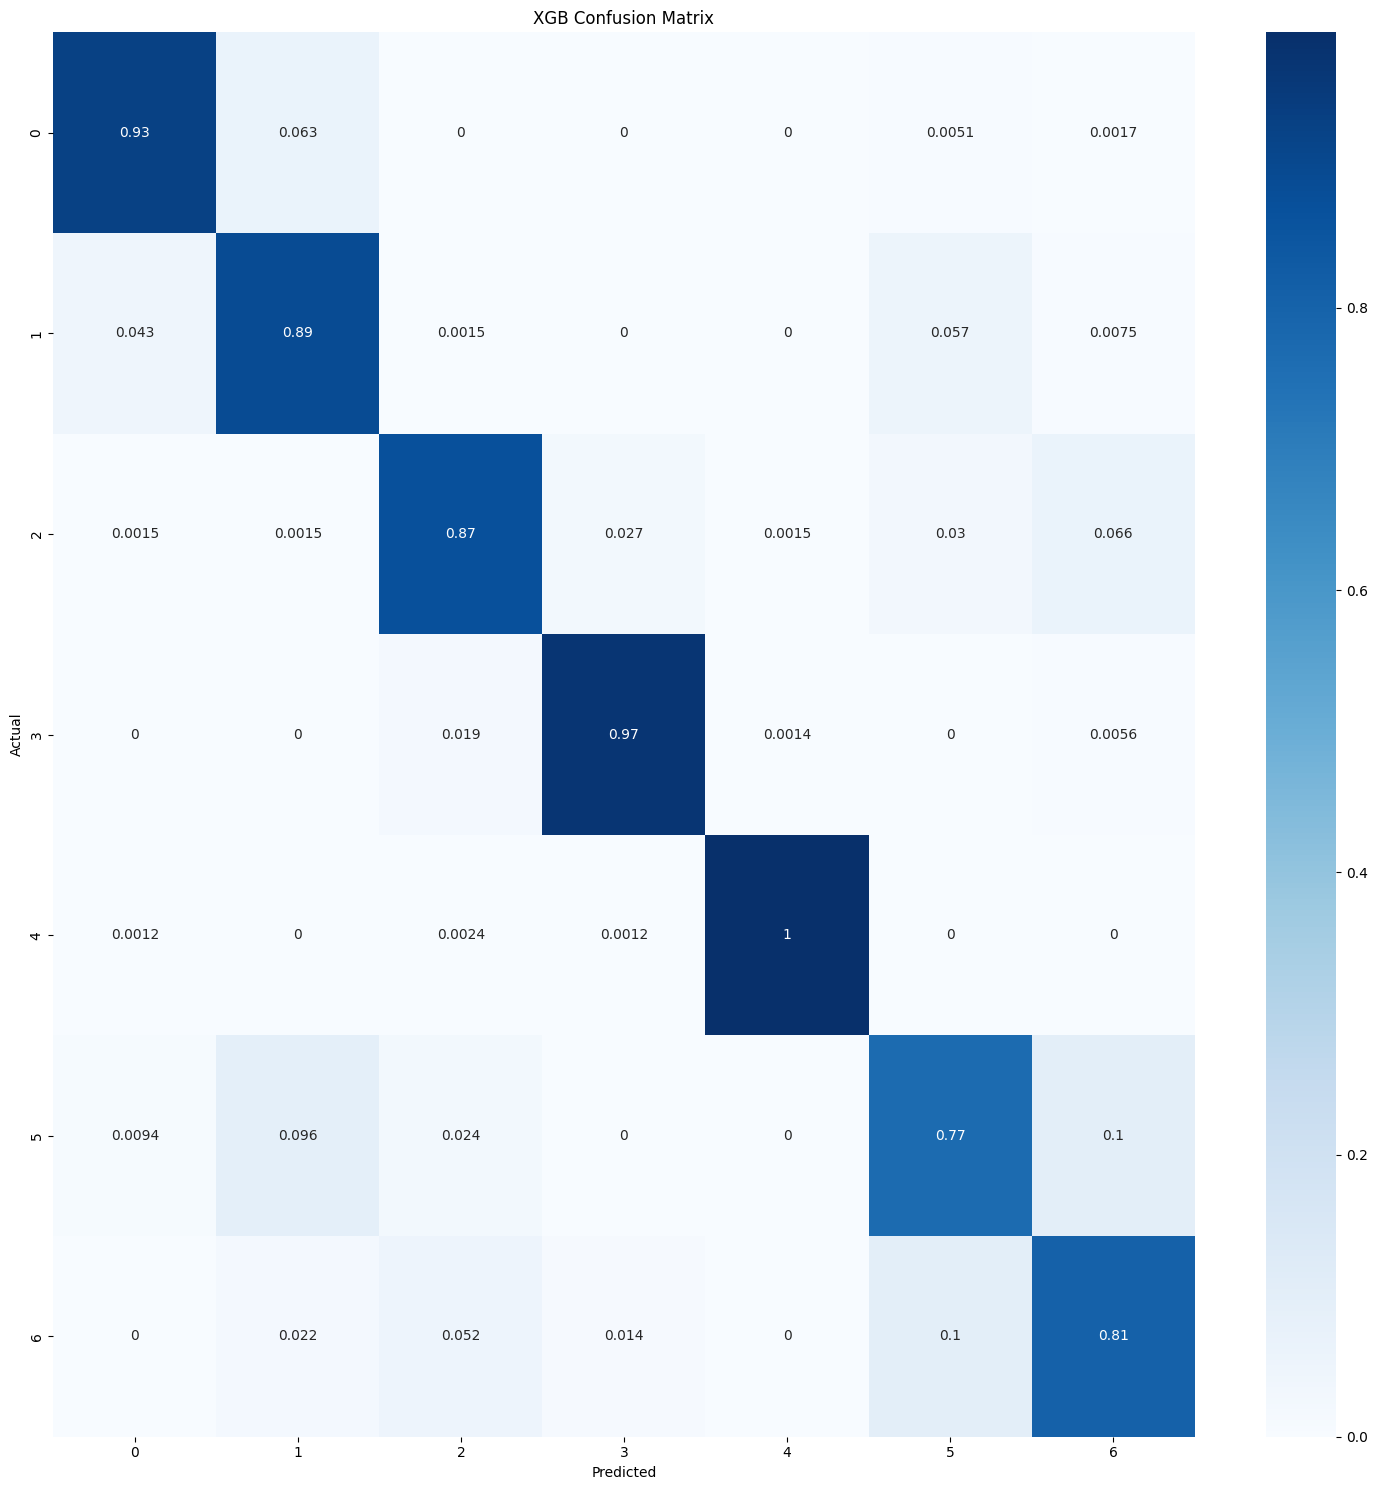

XGB accuracy_score: 0.9011805859204197


In [1275]:
# Build an XGBoost model
xgb_model1 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=3)
xgb_model1.fit(X_train, y_train)
y_pred_xgb = xgb_model1.predict(X_test)

# Calculate metrics for XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Print the metrics
print("XGBoost Model:")
print("Accuracy:", accuracy_xgb)
print("F1 Score:", f1_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_xgb, 'XGB Confusion Matrix')
print("XGB accuracy_score:", accuracy_score(y_test, y_pred_xgb))


LightGBM Model:
Accuracy: 0.9033668561434193
F1 Score: 0.9034903267626957
Precision: 0.9039334537186046
Recall: 0.9033668561434193
Confusion Matrix:


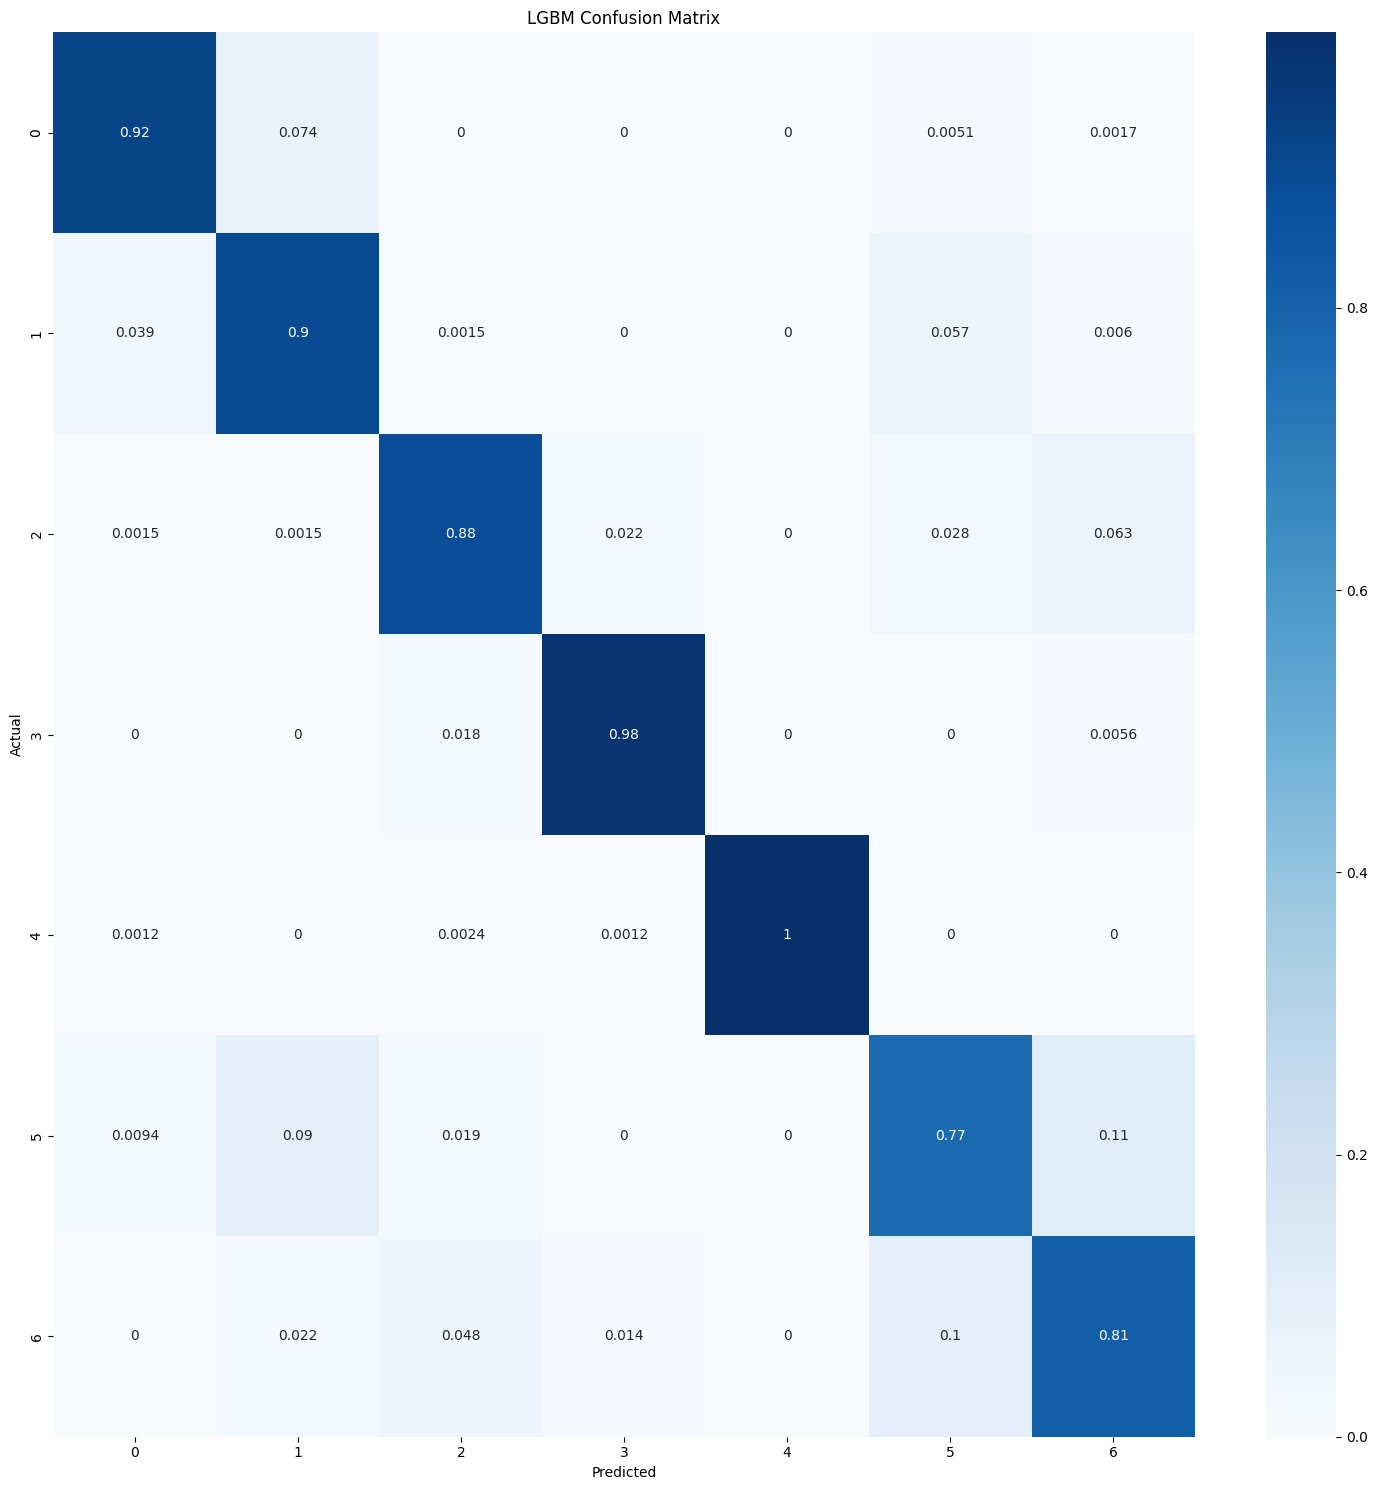

XGB accuracy_score: 0.9033668561434193


In [1276]:
# Build a LightGBM model
lgb_model = lgb.LGBMClassifier(**{'objective':'multiclass','num_class':7,'n_estimators': 405, 'learning_rate': 0.031725771326186744, 'max_depth': 8, 'min_child_samples': 24, 'num_leaves':23,
                               'subsample': 0.7458307885861184,'verbose':0, 'colsample_bytree': 0.5111460378911089, 'random_state': 42})
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# Calculate metrics for LightGBM model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb, average='weighted')
precision_lgb = precision_score(y_test, y_pred_lgb, average='weighted')
recall_lgb = recall_score(y_test, y_pred_lgb, average='weighted')
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

print("\nLightGBM Model:")
print("Accuracy:", accuracy_lgb)
print("F1 Score:", f1_lgb)
print("Precision:", precision_lgb)
print("Recall:", recall_lgb)
print("Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_lgb, 'LGBM Confusion Matrix')
print("XGB accuracy_score:", accuracy_score(y_test, y_pred_lgb))


Ensemble Model:
Accuracy: 0.9040227372103192
F1 Score: 0.903807400146831
Precision: 0.9038617599012027
Recall: 0.9040227372103192
Confusion Matrix:


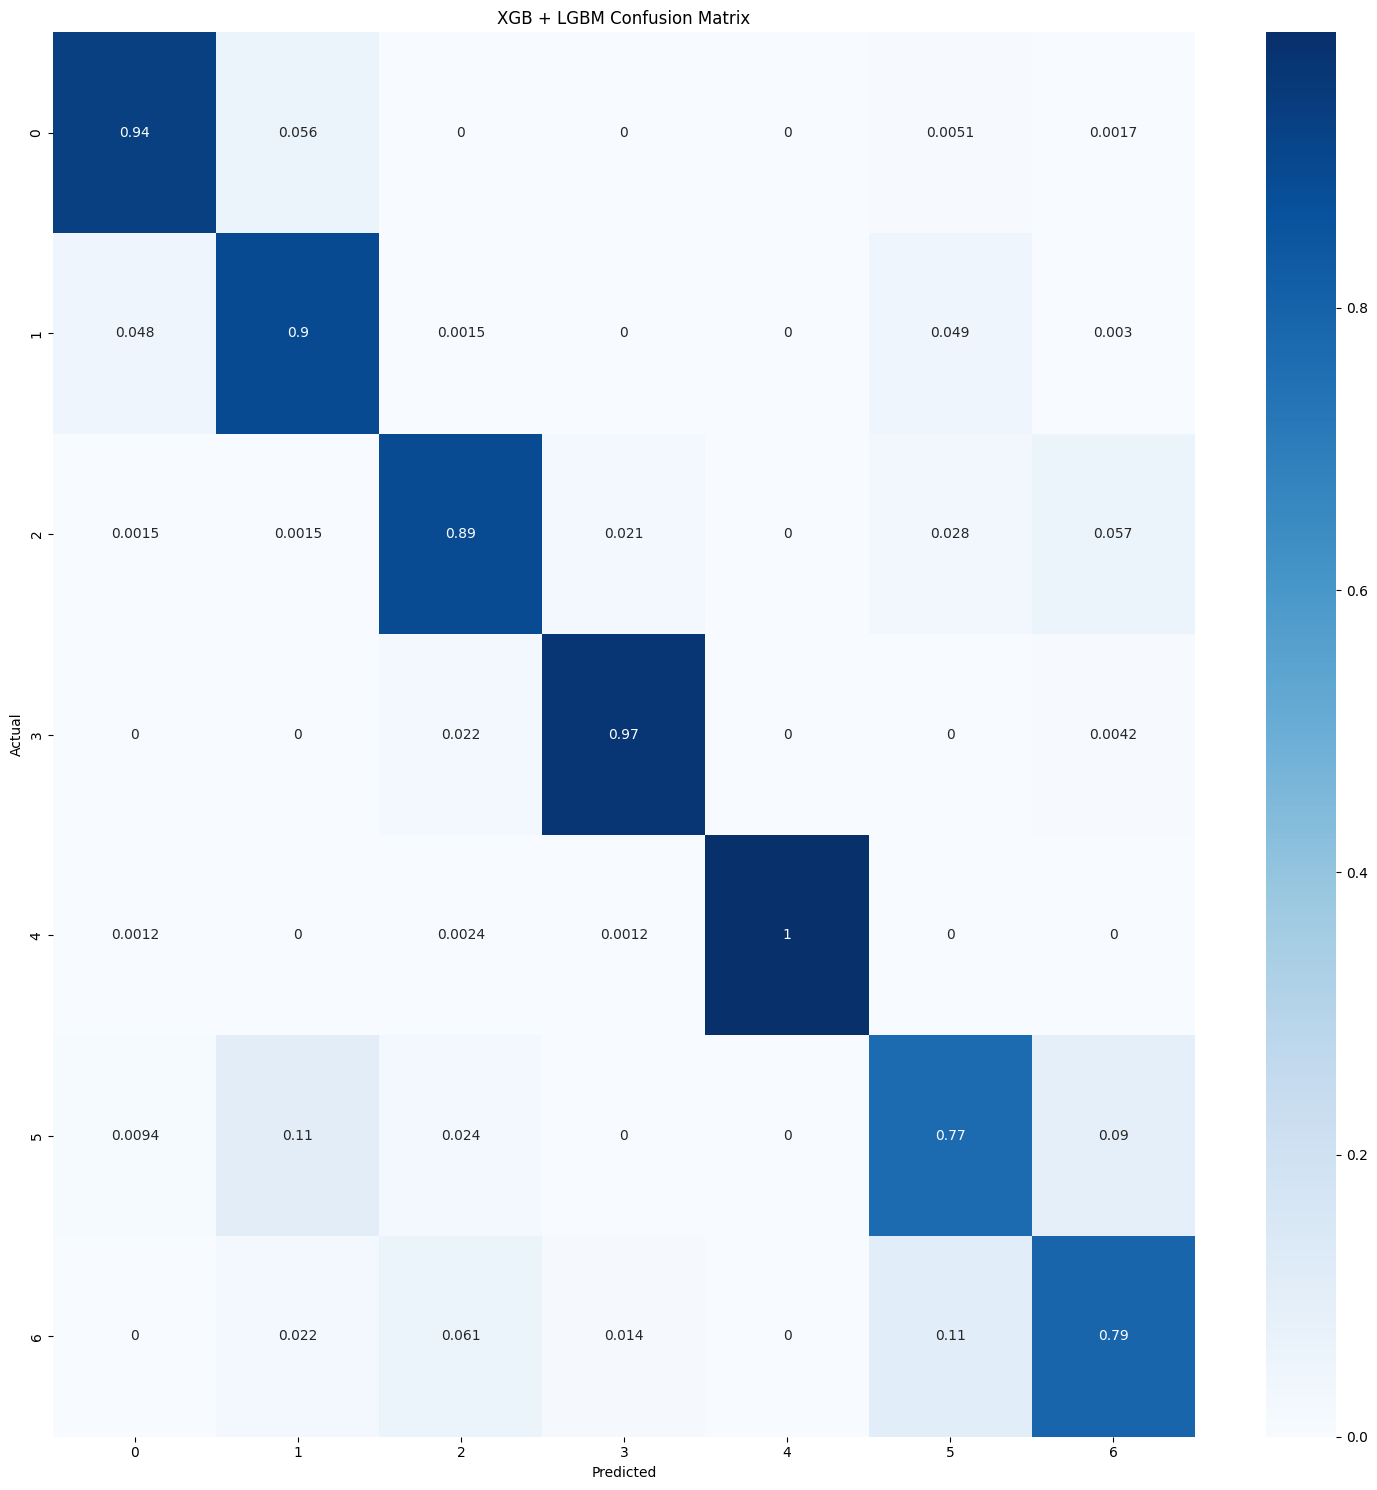

XGB accuracy_score: 0.9040227372103192


In [1277]:
# Combine predictions using bagging (voting)
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[('xgb', xgb_model1), ('lgb', lgb_model)], voting='hard')
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

# Calculate metrics for ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='weighted')
recall_ensemble = recall_score(y_test, y_pred_ensemble, average='weighted')
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)

print("\nEnsemble Model:")
print("Accuracy:", accuracy_ensemble)
print("F1 Score:", f1_ensemble)
print("Precision:", precision_ensemble)
print("Recall:", recall_ensemble)
print("Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_ensemble, 'XGB + LGBM Confusion Matrix')
print("XGB accuracy_score:", accuracy_score(y_test, y_pred_ensemble))

In [1278]:
# Reading the test data
test_data = pd.read_csv("playground-series-s4e2/test.csv")

# Extracting the 'id' column for submission
submission_ids = test_data['id']
test_data['Age_Weight_Interaction'] = test_data['Age'] * test_data['Weight']

# Dropping the 'id' column as it's not needed for prediction
test_data.drop(columns=['id'], inplace=True)


test_data[numerical_columns] = scaler.fit_transform(test_data[numerical_columns])

for col in binary_columns:
    if col != 'NObeyesdad':
        test_data[col] = label_encoder.fit_transform(test_data[col])


# One-hot encoding for categorical columns
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(test_data[col], prefix=col)
    test_data = pd.concat([test_data, one_hot_encoded], axis=1)
    test_data.drop(columns=[col], inplace=True)

# Making predictions on the test data using the ensemble model
predictions = ensemble_model.predict(test_data)

In [1279]:


# Mapping of original strings to numerical labels
label_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}

# Replace integers with corresponding strings
predicted_labels = [label_mapping[prediction] for prediction in predictions]

# Creating a DataFrame for submission
submission_df = pd.DataFrame({'id': submission_ids, 'NObeyesdad': predicted_labels})

# Saving the submission file
submission_df.to_csv("sample_submission.csv", index=False)
